In [53]:
import pybullet as p
import time
import math
import pathlib
import pickle
import os

import neat

import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.use('TkAgg')

import numpy as np

from objects import BallOnPlate

ballOnPlate = BallOnPlate(showGUI=False)

ref_alpha_vals = []
ref_beta_vals  = []
alpha_vals     = []
beta_vals      = []
t_vals         = []

x_vals         = []
y_vals         = []

r_x_vals         = []
r_y_vals         = []

prev_err   = [0, 0]
integr_err = [0, 0]
control    = np.array([0, 0])

ref_point = np.array([.7, .7])
posOnPlate = ballOnPlate.reset()
prevPosOnPlate = posOnPlate

with open('winner_ff', 'rb') as f:
    c = pickle.load(f)

configFname         = 'feedforward.cfg'
    
local_dir = str(pathlib.Path().absolute())
config_path = os.path.join(local_dir, configFname)
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)
    
net = neat.nn.FeedForwardNetwork.create(c, config)
    
while ballOnPlate.time < 20:

    start_time = time.time()

    t = ballOnPlate.time
    # ref_point = np.array([.5*math.cos(t), .5*math.sin(t)])

    err = ref_point - posOnPlate
    integr_err += err
    d_err = err - prev_err

    prev_err = err
    
    speed = (posOnPlate - prevPosOnPlate) #/BallOnPlate.D_T
    netInput = np.array([err[0], err[1], 
                         posOnPlate[0], posOnPlate[1], 
                         control[0], control[1], 
                         speed[0], speed[1]])
    prevPosOnPlate = posOnPlate
    
    netOutput = net.activate(netInput)

    pid_rates = [
        netOutput[0],
        netOutput[1],
        netOutput[2]
    ]
    
    control = ballOnPlate.control_get_PID(
        pid_rates,
        {
            'error': err,
            'error_diff': d_err,
            'error_integr': integr_err
        }
    )

    # # For plotting
    # js1 = p.getJointState(bodyUniqueId=plateId, jointIndex=0)
    # js2 = p.getJointState(bodyUniqueId=plateId, jointIndex=1)
    
    t_vals += [t]
    # alpha_vals += [js1[0]*180/math.pi]
    # beta_vals += [js2[0]*180/math.pi]
    # ref_alpha_vals += [target_alpha]
    # ref_beta_vals += [target_beta]

    posOnPlate, isEnd = ballOnPlate.step(control)
    if isEnd:
        break

    x_vals += [posOnPlate[0]]
    y_vals += [posOnPlate[1]]

    r_x_vals += [ref_point[0]]
    r_y_vals += [ref_point[1]]


    # key = p.getKeyboardEvents()
    # if p.B3G_RIGHT_ARROW in key:
    #     ref_point += [.001, 0, 0]
    # if p.B3G_LEFT_ARROW in key:
    #     ref_point -= [.001, 0, 0]
    # if p.B3G_UP_ARROW in key:
    #     ref_point += [0, .001, 0]
    # if p.B3G_DOWN_ARROW in key:
    #     ref_point -= [0, .001, 0]
    # if p.B3G_CONTROL in key:
        # posOnPlate, isEnd = ballOnPlate.step([0, 0])
        # if isEnd:
            # break
    #     ref_point = np.array([0., 0, 0])



    # if p.B3G_ALT in key or ballpos[2] < 0:
    #     # plt.plot(t_vals, alpha_vals, color = 'blue', linestyle = 'solid')
    #     # plt.plot(t_vals, beta_vals, color = 'red', linestyle = 'solid')

#plt.plot(x_vals, y_vals, color='blue')
#plt.plot(r_x_vals, r_y_vals, color='red')



    #     exit(1)

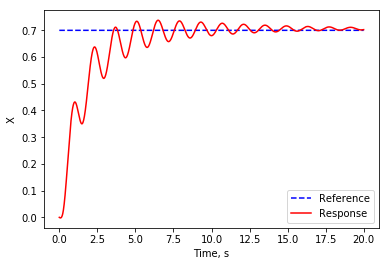

In [54]:
%matplotlib inline

plt.plot(t_vals, r_x_vals, color = 'blue', linestyle = 'dashed')
plt.plot(t_vals, x_vals, color = 'red',)

plt.xlabel('Time, s')
plt.ylabel('X')
plt.legend(['Reference', 'Response'])